# **Simulation of a crack growth in a square plate based on Peridynamic Theory**

Silling, S. A., & Askari, E. (2005). *A meshfree method based on the peridynamic model of solid mechanics*. *Computers & Structures, 83*(17-18), 1526-1535. https://doi.org/10.1016/j.compstruc.2004.11.026

*Author: Syed Talha Tirmizi*

This Jupyter Notebook delves into Peridynamic Theory, a computational framework for solid mechanics that replaces traditional partial differential equations with integral equations. The theory models particle interactions over a finite distance, inspired by molecular dynamics, allowing damage and fracture to emerge naturally from the equations of motion and constitutive models.

Key features of this notebook include:

- A step-by-step implementation of peridynamic models, including constitutive relationships and particle interactions.
- Visualization tools to analyze fracture propagation and material behavior during simulations.

## Setup

### Load Python Libraries

- **NumPy:** This library is fundamental for numerical computations in Python. It provides support for arrays, matrices, and many mathematical functions that operate on these data structures.
- **Matplotlib:** A plotting library for creating static, animated, and interactive visualizations in Python. It's particularly useful for generating plots, histograms, and other types of charts.
- **Pandas:** A Python library used for working with data sets. It has functions for analyzing, cleaning, exploring, and manipulating data.
- **Seaborn:** This Python library helps users visualize data through statistical graphics.
- **IPython.display.HTML:** This module from IPython is used to display rich HTML content within Jupyter notebooks, helpful for embedding animations and media.
- **PillowWriter:** This writer class in Matplotlib saves animations in GIF format, particularly useful when working with the FuncAnimation class to create smooth animations.

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd  
import seaborn as sns
from IPython.display import HTML

## Parameters

<center><img src="fig4-square_plate_containing_an_initial_center_crack.gif"/></center>
<br><br> <center> Figure - Square Plate Containing an Initial Center Crack (Silling & Askari, 2005) </center>

This section defines the key parameters used for the 2D plate simulation. 
#### Plate Geometry
- **Length (`length`)**: Length of the plate in meters (`0.05 m`).
- **Width (`width`)**: Width of the plate in meters (`0.05 m`).
- **Nodes in X and Y Directions (`nx`, `ny`)**: Number of nodes in the x and y directions (`50` nodes each).
- **Node Spacing (`dx`)**: Calculated as `length / nx`.
- **Number of Boundary Rows (`num_boundary_rows`)**: Number of additional boundary node layers (`3` rows).
- **Total Nodes (`total_nodes`)**: Total number of nodes, including boundary layers, calculated as `nx * (ny + num_boundary_rows * 2)`.

#### Crack Details
- **Half-Length of Initial Crack (`a0`)**: Half-length of the initial center crack (`0.005 m`).
- **Crack Length (`crack_length`)**: Total crack length, calculated as `2 * a0`.

#### Material Properties
- **Density (`rho`)**: Density of the material (`8000 kg/m³`).
- **Elastic Modulus (`E`)**: Elastic modulus (`192 GPa`).
- **Poisson's Ratio (`poisson_ratio`)**: Poisson's ratio (`1/3`).
- **Bulk Modulus (`k`)**: Computed as `E / (3 * (1 - 2 * poisson_ratio))`.
- **Peridynamic Horizon (`delta_x`)**: Defined as `3.015 * dx`.
- **Material Constant (`c`)**: Computed as `18 * k / (π * delta_x^4)` (alternative: `(9 * E) / (π * thick * delta_x^3)`).
- **Critical Stretch (`critical_stretch`)**: Failure criterion for bond breakage (`0.02`).

#### Node Properties
- **Node Radius (`radius_of_node`)**: Defined as `dx / 2`.
- **Node Area (`area_of_node`)**: Calculated as `dx * dx`.
- **Node Volume (`vol`)**: Approximated as `area_of_node * dx`.
- **Plate Thickness (`thick`)**: Equal to the node spacing (`dx`).

#### Time Setup
- **Total Simulation Time (`total_time`)**: Total time for the simulation (`15 µs` or `15e-6 s`).
- **Time Step (`delta_t`)**: The simulation time step (`12 ns` or `1.2e-8 s`).
- **Total Time Steps (`total_time_steps`)**: Number of time steps, calculated as `total_time / delta_t`.


In [ ]:
#Define the dimensions of the 2D Plate
length = 0.05                #Length of the plate
width = 0.05                 #width of the plate

#Definte the number of nodes in x & y directions
nx = 50                     #Number of nodes in x-direction
ny = 50                     #Number of nodes in y-direction

#Crack
a0 = 0.005                  #Half length of the initial center crack 
crack_length = 2 * a0       #Total length of the initial center crack

#Other Properties  
dx = length/nx              #Spacing
num_boundary_rows = 3       #Number of boundary regions
total_nodes = nx * (ny + (num_boundary_rows*2)) #Total number of nodes in the 2D plate
delta_x = 3.015 * dx          #Horizon
radius_of_node = dx / 2     #Radius around the node
area_of_node = dx * dx      #Area of the radius around the node
vol = area_of_node * dx     #Volume of the node
thick = dx                  #Total thickness of the plate
rho = 8000                 #rhoity
E = 192e9                   #Elastic Modulus
poisson_ratio = 1/3         #Poisson's ratio
k = E / (3*(1-2*poisson_ratio))
c = 18 * k / np.pi / delta_x**4
#c = (9 * E ) / (np.pi * thick * delta_x**3) #Material constant

critical_stretch = 0.02     #Critical stretch for bond fail_matrixure

#Time
total_time = 15e-6             #Total time of simulation
delta_t = 1.2e-8
total_time_steps = int(total_time/delta_t)

## Create Grid Geometry

This section generates the spatial coordinates for the internal and boundary regions of the 2D plate, ensuring a structured grid layout for the simulation. The points are divided into internal region points and boundary region points (bottom and top), then combined into a single array.

#### Internal Region Points
- **`x_internal` and `y_internal`**: Define evenly spaced points along the x and y directions for the internal region. The spacing is determined by `dx`.
- **`np.meshgrid(x_internal, y_internal)`**: Creates a grid of x and y coordinates.
- **`internal_points`**: A 2D array of the internal region's coordinates, flattened into `[x, y]` pairs using `np.column_stack()`.

#### Boundary Region Points
- **X-Direction (`x_boundary`)**: The same as `x_internal` since the boundary points align horizontally with the internal grid.
- **Bottom Boundary (`y_bottom`)**: Points are generated below the internal region, spaced by `dx` and extending over `num_boundary_rows`.
- **Top Boundary (`y_top`)**: Points are generated above the internal region, mirroring the bottom boundary's spacing and number of rows.
- **`np.meshgrid` for Bottom and Top**: Produces grid coordinates for the bottom and top boundary regions:
  - `bottom_points`: Flattened `[x, y]` pairs for the bottom boundary.
  - `top_points`: Flattened `[x, y]` pairs for the top boundary.

#### Combined Coordinates
- **`coord`**: Combines all points (internal, bottom, and top) into a single 2D array of shape `(total_nodes, 2)`, where each row represents `[x, y]` coordinates.

#### Node Count
- **`total_internal_nodes`**: Number of nodes in the internal region.
- **`total_bottom_nodes`**: Cumulative count of internal and bottom boundary nodes.
- **`total_top_nodes`**: Total count of all nodes, including internal, bottom, and top regions.


In [3]:
# Generate internal region points
x_internal = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, nx)
y_internal = np.linspace(-width / 2 + dx / 2, width / 2 - dx / 2, ny)
X_internal, Y_internal = np.meshgrid(x_internal, y_internal)
internal_points = np.column_stack((X_internal.ravel(), Y_internal.ravel()))

# Generate boundary region points (bottom and top)
x_boundary = np.linspace(-length / 2 + dx / 2, length / 2 - dx / 2, nx)
y_bottom = np.linspace(-width / 2 - dx / 2, -width / 2 - num_boundary_rows * dx + dx / 2, num_boundary_rows)
y_top = np.linspace(width / 2 + dx / 2, width / 2 + num_boundary_rows * dx - dx / 2, num_boundary_rows)

X_bottom, Y_bottom = np.meshgrid(x_boundary, y_bottom)
X_top, Y_top = np.meshgrid(x_boundary, y_top)

bottom_points = np.column_stack((X_bottom.ravel(), Y_bottom.ravel()))
top_points = np.column_stack((X_top.ravel(), Y_top.ravel()))

# Combine all points
coord = np.zeros((total_nodes, 2))
coord = np.vstack((internal_points, bottom_points, top_points))

#Count total number of nodes 
total_internal_nodes = len(internal_points)
total_bottom_nodes = total_internal_nodes + len(bottom_points)
total_top_nodes = total_bottom_nodes + len(top_points)

## Create Binary Failure Matrix

This section initializes the required arrays and calculates the family relationships between nodes (material points) in the 2D plate based on their pairwise distances. It also sets up a failure matrix to track bond failures during the simulation.

#### Key Parameters and Arrays
- **`maxfam`**: Maximum number of material points within the horizon of any material point. Set to `100`.
- **`fail_matrix`**: A flag array initialized with ones, indicating that no bonds have failed at the start. The shape is `(total_nodes, maxfam)`.

##### Arrays for Family Tracking:
1. **`nodes_idx_array`**: Stores the starting index of each node's family in `nodes_idx_in_families_array`.
2. **`total_in_families_array`**: Tracks the total number of family members for each node.
3. **`nodes_idx_in_families_array`**: A large flat array that stores the indices of family members for all nodes.

#### Pairwise Distance Calculation
- **`dist_matrix`**: A matrix of pairwise distances between all nodes, calculated efficiently using NumPy broadcasting:
  - `coord[:, np.newaxis, :] - coord[np.newaxis, :, :]` computes the differences in x and y coordinates between all node pairs.
  - `np.sqrt(np.sum(..., axis=2))` calculates the Euclidean distance for each pair.

- **Diagonal Set to Infinity**: The diagonal of `dist_matrix` is set to infinity using `np.fill_diagonal()` to prevent nodes from being considered as their own family members.

#### Identify Family Members
- **`within_horizon`**: A boolean matrix indicating whether each node pair is within the horizon (`delta_x`).

#### Populating Family Arrays
- **Loop Over Nodes**:
  - For each node `i`, `np.where(within_horizon[i])[0]` identifies indices of family members.
  - The number of family members is stored in `total_in_families_array[i]`.
  - The starting index for the family in `nodes_idx_in_families_array` is stored in `nodes_idx_array[i]`.
  - Family member indices are added to `nodes_idx_in_families_array` starting from `current_index`.

- **`current_index`**: Tracks the current position in `nodes_idx_in_families_array`, ensuring efficient storage of family member indices.

#### Memory Optimization
- After processing all nodes, `nodes_idx_in_families_array` is trimmed to remove unused space, improving memory efficiency.

In [4]:
#initialization of fail_matrix flag array
maxfam = 100 #Max number of material points inside the horizon of the material point

fail_matrix = np.ones((total_nodes, maxfam), dtype=int)

# Arrays to track the family members
nodes_idx_array = np.zeros(total_nodes, dtype=int)
total_in_families_array = np.zeros(total_nodes, dtype=int)
nodes_idx_in_families_array = np.zeros(100000000, dtype=int)

#Calculate pairwise distances using broadcasting
dist_matrix = np.sqrt(np.sum((coord[:, np.newaxis, :] - coord[np.newaxis, :, :]) ** 2, axis = 2))

#Set diagonal to infinity to avoid self-selection
np.fill_diagonal(dist_matrix, np.inf)

#Identify family members for each material point
within_horizon = dist_matrix <= delta_x

#Fill 'total_in_families_array', 'nodes_idx_in_families_array', and 'nodes_idx_array' arrays
current_index = 0 #Track the current position in nodes_idx_in_families_array

for i in range(total_nodes):
    family_members = np.where(within_horizon[i])[0]  # Get family members' indices
    num_members = len(family_members)  # Number of family members

    # Store the number of family members
    total_in_families_array[i] = num_members

    # Update the `nodes_idx_array` array
    nodes_idx_array[i] = current_index

    # Store family member indices in `nodes_idx_in_families_array`
    nodes_idx_in_families_array[current_index:current_index + num_members] = family_members

    # Move the current index forward
    current_index += num_members

# Trim unused space in `nodes_idx_in_families_array` for efficiency
nodes_idx_in_families_array = nodes_idx_in_families_array[:current_index]

### Insert Crack

This section identifies bonds that penetrate the crack and updates the failure matrix (`fail_matrix`) accordingly. 

#### Key Variables
- **Flattened Coordinates**:
  - `x_coords` and `y_coords`: Extract the x and y coordinates of all nodes from the `coord` array for easier vectorized operations.

- **Boolean Mask for Bond Penetration**:
  - **`bond_penetrates_crack(i, selected_node)`**: 
    - A helper function that checks whether the bond between node `i` and its family member `selected_node` crosses the crack surface (`y = 0`). 
    - Logic:
      - If one node is above (`y > 0`) and the other is below (`y < 0`) the crack, the bond penetrates the crack.

- **Crack Position Check**:
  - **`is_crack_position(x)`**:
    - Another helper function that verifies whether the x-coordinate `x` lies within the bounds of the crack (`-crack_length/2` to `crack_length/2`), with a small tolerance (`1e-10`) for numerical precision.

#### Loop Logic
- **Outer Loop (Over Nodes)**:
  - Iterates over all nodes in the domain (`i`).

- **Inner Loop (Over Family Members)**:
  - Iterates over the family members of the current node (`i`) using the `nodes_idx_in_families_array`.

- **Crack Penetration Check**:
  - For each bond:
    1. **`bond_penetrates_crack(i, selected_node)`**: Check if the bond crosses the crack surface.
    2. **`is_crack_position(x_coords[i])` or `is_crack_position(x_coords[selected_node])`**: Verify if either node involved in the bond lies at the crack's x-position.
    3. **Update `fail_matrix`**: If both conditions are met, the bond is marked as failed by setting `fail_matrix[i, j] = 0`.

In [7]:
# Flattened coordinates for easier vectorized operations
x_coords = coord[:, 0]
y_coords = coord[:, 1]

# Create a boolean mask to identify if a bond penetrates the crack
def bond_penetrates_crack(i, selected_node):
    return (
        (y_coords[selected_node] > 0.0 and y_coords[i] < 0.0) or 
        (y_coords[i] > 0.0 and y_coords[selected_node] < 0.0)
    )

def is_crack_position(x):
    return abs(x) <= crack_length / 2.0 + 1.0e-10

# Loop through nodes and their families
for i in range(total_nodes):
    for j in range(total_in_families_array[i]):
        selected_node = nodes_idx_in_families_array[nodes_idx_array[i] + j]

        # Check if the bond penetrates the crack surface
        if bond_penetrates_crack(i, selected_node):
            if is_crack_position(x_coords[i]) or is_crack_position(x_coords[selected_node]):
                fail_matrix[i, j] = 0

### Displacement Calculations

This section implements the core simulation loop for the peridynamic model. It updates the displacements, velocities, accelerations, and forces for all material points at each time step, applying boundary conditions and calculating interactions between nodes.

#### Initialization
- **Material Point Properties**:
  - `vel`: Velocity of all nodes, initialized to zero.
  - `disp`: Displacement of all nodes, initialized to zero.
  - `bforce`: Body force acting on each node, initialized to zero.
  - `peridynamic_force`: The total force acting on each node due to peridynamic interactions, initialized to zero.
  - `acc`: Acceleration of each node, initialized to zero.
  - `result_array`: Stores displacement and analytical displacement of internal nodes for all time steps.

#### Time Integration Loop
The simulation iterates over a total of `total_time_steps`. For each time step:

1. **Boundary Conditions**:
   - The top and bottom boundary nodes are assigned specific velocities and displacements along the y-direction:
     - Bottom nodes move downward with a velocity of `-40.0` m/s.
     - Top nodes move upward with a velocity of `40.0` m/s.
   - Displacement is updated linearly based on the current time.

2. **Peridynamic Force Calculation**:
   - For each internal node:
     - Identify its family members using the `nodes_idx_in_families_array`.
     - Compute the initial distance (`ksi`) and the deformed distance (`eta`) between the node and its family members.
     - **Force Calculation**:
       - Forces are computed only for bonds that have not failed (using `fail_matrix`).
       - The peridynamic force is calculated as:
         \[
         \text{Force} = c \cdot \frac{\eta - \xi}{\xi} \cdot \text{vol} \cdot \frac{\Delta x}{\eta}
         \]
       - Summed forces in x and y directions are added to the total `peridynamic_force`.

3. **Failure Criterion**:
   - Bonds exceeding the `critical_stretch` value are marked as failed in the `fail_matrix`, with additional checks for nodes in the "no-fail zone" near the quarter length of the plate.

4. **Update Acceleration, Velocity, and Displacement**:
   - Internal nodes and boundary nodes are updated separately:
     - Acceleration is computed as the net force divided by material density (`rho`).
     - Velocity and displacement are updated using time integration with the time step `delta_t`.

5. **Store Results**:
   - The `result_array` is updated with the current coordinates and displacements of internal nodes for the current time step.

#### Summary
This loop combines the key aspects of the peridynamic simulation:
- **Interaction Forces**: Capturing material point interactions and calculating forces.
- **Boundary Conditions**: Imposing controlled motion on boundary nodes.
- **Dynamic Updates**: Iteratively updating positions, velocities, and accelerations using time integration.
- **Failure Handling**: Tracking bond failures dynamically as the simulation progresses.

In [ ]:
# Initialize
vel = np.zeros((total_nodes, 2))  # Velocity of material points
disp = np.zeros((total_nodes, 2))  # Displacement of material points
bforce = np.zeros((total_nodes, 2)) 


peridynamic_force = np.zeros((total_nodes, 2))  # total peridynamic force acting on a material point
acc = np.zeros((total_nodes, 2))  # acceleration of a material point
result_array = np.zeros((total_time_steps, total_internal_nodes, 4))  # Peridynamic displacement and Analytical displacement of all points at all time steps

for iteration in range(1, total_time_steps + 1):
    
    current_time = iteration * delta_t
    #print(f"{iteration}/{total_time_steps}")

    # Application of boundary conditions at the top and bottom edges
    vel[total_internal_nodes:total_bottom_nodes, 1] = -40.0
    disp[total_internal_nodes:total_bottom_nodes, 1] = -40.0 * iteration * delta_t

    vel[total_bottom_nodes:total_top_nodes, 1] = 40.0
    disp[total_bottom_nodes:total_top_nodes, 1] = 40.0 * iteration * delta_t

    peridynamic_force[:, :] = 0.0

    for i in range(total_internal_nodes):
        cnode_start = nodes_idx_array[i]
        cnode_end = cnode_start + total_in_families_array[i]
        cnode_indices = nodes_idx_in_families_array[cnode_start:cnode_end]
        ccoords = coord[cnode_indices]
        cdisps = disp[cnode_indices]
        ksi = np.sqrt((ccoords[:, 0] - coord[i, 0]) ** 2 + (ccoords[:, 1] - coord[i, 1]) ** 2)
        eta = np.sqrt((ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) ** 2 + (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) ** 2)

        fail_mask = fail_matrix[i, :total_in_families_array[i]] == 1
        dforce1 = np.where(fail_mask, c * (eta - ksi) / ksi * vol * (ccoords[:, 0] + cdisps[:, 0] - coord[i, 0] - disp[i, 0]) / eta, 0.0)
        dforce2 = np.where(fail_mask, c * (eta - ksi) / ksi * vol * (ccoords[:, 1] + cdisps[:, 1] - coord[i, 1] - disp[i, 1]) / eta, 0.0)

        peridynamic_force[i, 0] += np.sum(dforce1)
        peridynamic_force[i, 1] += np.sum(dforce2)

        no_fail_zone = (np.abs((eta - ksi) / ksi) > critical_stretch) & (np.abs(coord[i, 1]) <= (length / 4.0))
        fail_matri## Node Generation
amic_force + bforce) / rho
    vel[:total_internal_nodes] += acc[:total_internal_nodes] * delta_t
    disp[:total_internal_nodes] += vel[:total_internal_nodes] * delta_t

    acc[total_internal_nodes:total_bottom_nodes, 0] = (peridynamic_force[total_internal_nodes:total_bottom_nodes, 0] + bforce[total_internal_nodes:total_bottom_nodes, 0]) / rho
    vel[total_internal_nodes:total_bottom_nodes, 0] += acc[total_internal_nodes:total_bottom_nodes, 0] * delta_t
    disp[total_internal_nodes:total_bottom_nodes, 0] += vel[total_internal_nodes:total_bottom_nodes, 0] * delta_t

    acc[total_bottom_nodes:total_top_nodes, 0] = (peridynamic_force[total_bottom_nodes:total_top_nodes, 0] + bforce[total_bottom_nodes:total_top_nodes, 0]) / rho
    vel[total_bottom_nodes:total_top_nodes, 0] += acc[total_bottom_nodes:total_top_nodes, 0] * delta_t
    disp[total_bottom_nodes:total_top_nodes, 0] += vel[total_bottom_nodes:total_top_nodes, 0] * delta_t

    result_array[iteration - 1, :, :4] = np.hstack((coord[:total_internal_nodes], disp[:total_internal_nodes]))

## Visualization

This section generates an animated scatter plot to visualize material point displacements over time, with magnified displacements and a color map indicating magnitudes.

### Key Details
- **Magnification**: Displacements are scaled by `magnifier` for better visibility.
- **Color Map**: The `jet` colormap represents displacement magnitudes, with a color bar added for reference.
- **Axis Limits**: Both x and y axes are set between `-0.03 m` and `0.03 m`.

### Animation Functions
- **`init()`**: Initializes the plot with axis limits.
- **`update(current_time_step)`**: Updates the scatter plot for each frame, adjusting positions and colors based on displacements.

### Output
- The animation is saved as `dec_scatter_plot_animation-dpi50.gif` with 30 FPS, providing a clear visual representation of deformation and displacement behavior over time.

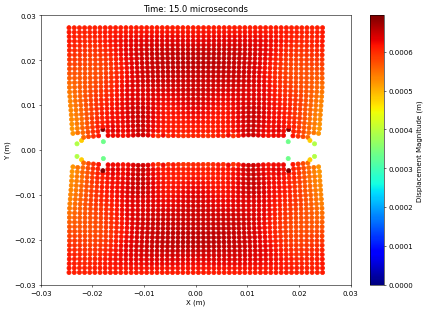

In [ ]:
# Parameters for magnification and figure
magnifier = 4.5
fig, ax = plt.subplots(figsize=(10, 7), dpi=50)  # Create a figure and axis

# Color map limits based on displacement magnitude
vmin = np.sqrt(result_array[:, :, 2]**2 + result_array[:, :, 3]**2).min()
vmax = np.sqrt(result_array[:, :, 2]**2 + result_array[:, :, 3]**2).max()
cmap = cm.jet

# Color bar
sm = cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin, vmax)  # Set the color limits based on the range
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Displacement Magnitude (m)')


def init():
    ax.set_xlim(-0.03, 0.03)  # Set appropriate x-axis limits
    ax.set_ylim(-0.03, 0.03)  # Set appropriate y-axis limits
    return []

# Update each frame
def update(current_time_step):
    ax.clear()  # Clear the axis
    scatter = ax.scatter(
        result_array[current_time_step, :, 0] + (magnifier * result_array[current_time_step, :, 2]),
        result_array[current_time_step, :, 1] + (magnifier * result_array[current_time_step, :, 3]),
        c=np.sqrt(result_array[current_time_step, :, 2]**2 + result_array[current_time_step, :, 3]**2),
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )
    ax.set_xlim(-0.03, 0.03)  
    ax.set_ylim(-0.03, 0.03)  
    ax.set_title(f"Time: {np.round(((current_time_step+1)/1250) * 15, 4)} microseconds")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    return scatter,


anim = FuncAnimation(
    fig, update, frames=range(total_time_steps),
    init_func=init, blit=False, repeat=False
)

anim.save('dec_scatter_plot_animation-dpi50.gif', writer='pillow', fps=30)

## Conclusion

In this notebook, I implemented the peridynamic theory to simulate crack propagation and material behavior, following the framework outlined in [Silling & Askari, 2005](https://www.sciencedirect.com/science/article/pii/S0045794905000805?via%3Dihub). 

### Key Insights
- The peridynamic approach offers a straightforward way to model discontinuities, such as cracks, without relying on special criteria or remeshing. This is due to its use of integral equations rather than partial differential equations.
- Crack growth and failure emerge naturally from the equations of motion and constitutive models, making this method both robust and flexible for simulating dynamic fracture mechanics.
- The visualizations provided a clear picture of how displacement fields and cracks evolve over time.

### Next Steps
This implementation can be expanded in several ways:
1. Extend the model to three-dimensional simulations to explore more complex fracture patterns and behaviors.
2. Study the effects of different parameters, such as horizon size, material properties, and boundary conditions, to gain deeper insights into their roles in crack propagation.
3. Apply the peridynamic theory to practical problems, such as predicting material fatigue or analyzing impact dynamics in real-world scenarios.

Overall, this work demonstrates the potential of the peridynamic theory as a powerful alternative to classical solid mechanics, offering unique advantages in the study of fractures and material failure.
